### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import skimage.io as io

In [4]:
import seaborn as sns
import uuid
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [5]:
from preprocess.common import load_nii
from models import *
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import *
from utils.training import *

In [6]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import *
from captum.attr import visualization as viz

In [7]:
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import rcParams
rcParams['axes.titlepad'] = 15

## Load Model

Copy model to captum.ipynb path

In [8]:
model_name = "resnet18_pspnet_classification"
crop_size = 224
model = model_selector(model_name, in_size=(crop_size, crop_size), num_classes=1)  # 1 class A vs. B
model_total_params = sum(p.numel() for p in model.parameters())

In [9]:
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model_checkpoint = "model_resnet18_pspnet_classification_best_accuracy.pt"
model.load_state_dict(torch.load(model_checkpoint))
model.eval()
print("Model loaded from pretrained checkpoint: {}".format(model_checkpoint))

Model loaded from pretrained checkpoint: model_resnet18_pspnet_classification_best_accuracy.pt


## Load Data

In [10]:
VENDOR_MAP = {'A': 0, 'B': 1, 'C': 2}
VENDOR_MAP_REVERSE = {0:'A', 1:'B', 2:'C'}

In [11]:
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


In [12]:
data_partition = "validation"
normalization = "standardize"
fold_system = "patient"
label_type = "vendor_label_binary"
data_fold = 0


val_dataset = MMsDataset(
    mode=data_partition, transform=val_aug, img_transform=[],
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    train_fold=data_fold, val_fold=None,
)


---------------------------------------------------
Note: Using only Vendor 'A' and 'B' - Binary classification
---------------------------------------------------



In [13]:
val_dataset.df["Vendor"].unique()

array(['A', 'B'], dtype=object)

In [14]:
batch_size = 6
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

## Predict

In [120]:
batch = next(iter(val_loader))
sample = batch[0]
target = batch[1]
sample_path = batch[2][0]

output = model(sample)

### Binary Case

In [121]:
predicted = torch.round(nn.Sigmoid()(output))
predicted_list = [int(i) for i in predicted.squeeze().tolist()]

In [122]:
print("Real: {}".format(target))
print("Predicted: {}".format(predicted_list))

Real: tensor([1, 0, 0, 1, 0, 0])
Predicted: [1, 0, 1, 1, 0, 0]


### Multiclass case

ToDo

# Captum

In [19]:
os.makedirs("captum",exist_ok=True)

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#000000'),
    (0.25, '#ffffff'),
    (1, '#ffffff')], 
    N=512
)

In [ ]:
sample_indx = 2
sample_img = sample[sample_indx,0,...].data.cpu().numpy()

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(sample[sample_indx,...].unsqueeze(0).cuda(), target=target[sample_indx].item(), n_steps=200)


comp = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             sample_img,
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,  fig_size=(10, 10),
                             signs=['all','positive'], titles=["Original","Attributions"],
                             outlier_perc=1)

fig = comp[1][0].get_figure()
real_str = VENDOR_MAP_REVERSE[target[sample_indx].item()]
predict_str = VENDOR_MAP_REVERSE[predicted_list[sample_indx]]
fig.suptitle("Linnear Segmented - Target {} predicted as {}".format(real_str, predict_str), y=0.83)
fig.savefig("captum/{}as{}_linear_segmented_{}.png".format(real_str, predict_str, str(uuid.uuid4().hex) ), transparent=False, dpi=250, bbox_inches="tight")

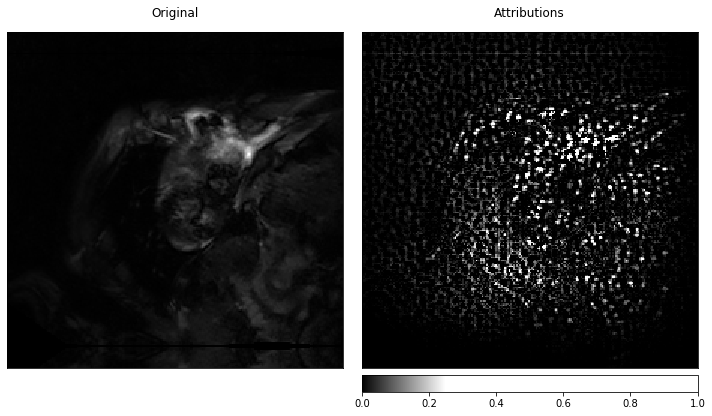

In [123]:
for sample_indx in range(len(sample)):
    
    real_str = VENDOR_MAP_REVERSE[target[sample_indx].item()]
    predict_str = VENDOR_MAP_REVERSE[predicted_list[sample_indx]]
    
    if real_str!=predict_str:

        sample_img = sample[sample_indx,0,...].data.cpu().numpy()

        integrated_gradients = IntegratedGradients(model)
        attributions_ig = integrated_gradients.attribute(sample[sample_indx,...].unsqueeze(0).cuda(), target=0, n_steps=50)


        comp = viz.visualize_image_attr_multiple(
            np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
            sample_img,
            methods=["original_image", "heat_map"],
            cmap=default_cmap,
            show_colorbar=True,  fig_size=(10, 10),
            signs=['all','positive'], titles=["Original","Attributions"],
            outlier_perc=1
        )

        fig = comp[1][0].get_figure()
        fig.suptitle("Linnear Segmented - Target {} predicted as {}".format(real_str, predict_str), y=0.83)
        fig.savefig("captum/{}as{}_linear_segmented_{}.png".format(real_str, predict_str, str(uuid.uuid4().hex) ), transparent=False, dpi=250, bbox_inches="tight")
        plt.close()

In [ ]:
sample_indx